# Clean dataset using influence functions and neural networks


This notebook cares about how to calculate the most influential points for the wine classification dataset.

In [8]:
from sklearn.datasets import load_wine
from valuation.utils.dataset import Dataset

wine_bunch = load_wine(as_frame=True)
dataset = Dataset.from_sklearn(wine_bunch)

is straightforward using python. As usual a closer inspection of the data is helpful. The data is plotted by the following function.

/home/markus/miniconda3/envs/valuation/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


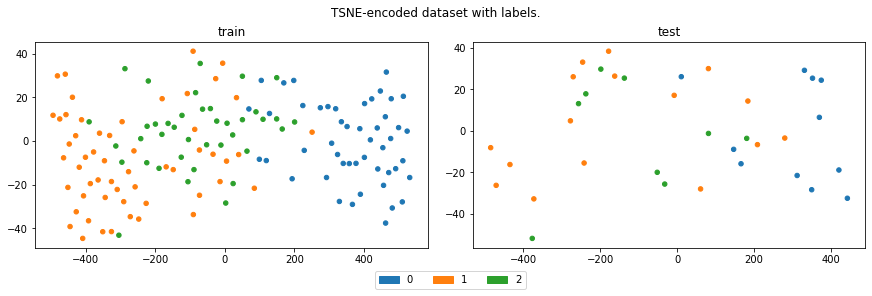

In [9]:
from valuation.utils import dataset_tsne_encode, dataset_to_json
from valuation.utils.plotting import plot_datasets

tsne_dataset = dataset_tsne_encode(dataset)
tsne_dateset_json = dataset_to_json(tsne_dataset)
plot_datasets(tsne_dateset_json, s=20, suptitle="TSNE-encoded dataset with labels.")

## Fit a neural network to the data

First, a 2-layer neural network is created and fitted with pyDVL.

In [3]:
from copy import copy
import torch
from valuation.models.neural_network_torch_model import NNTorchModel
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

x_transformer = MinMaxScaler()

transformed_dataset = copy(dataset)
transformed_dataset.x_train = x_transformer.fit_transform(transformed_dataset.x_train)
transformed_dataset.x_test = x_transformer.transform(transformed_dataset.x_test)
feature_dimension = transformed_dataset.x_train.shape[1]
num_classes = 3

model = PyTorchSupervisedModel(
    model=NNTorchModel(feature_dimension, num_classes, [16, 16]),
    objective=F.cross_entropy,
    num_epochs=300,
    batch_size=32,
    optimizer=PyTorchOptimizer.ADAM,
    optimizer_kwargs={
        "lr": 0.001,
        "weight_decay": 0.001,
        "cosine_annealing": True,
    },
    y_dtype=torch.long
)
model.fit(
    transformed_dataset.x_train,
    transformed_dataset.y_train
)

Training loss: 1.1720188856124878
Training loss: 1.2063883543014526
Training loss: 1.1856623888015747
Training loss: 1.166406273841858
Training loss: 1.1728156805038452
Training loss: 1.155903935432434
Training loss: 1.1833268404006958
Training loss: 1.1664451360702515
Training loss: 1.1506505012512207
Training loss: 1.1518100500106812
Training loss: 1.1408581733703613
Training loss: 1.1613070964813232
Training loss: 1.1481013298034668
Training loss: 1.1356691122055054
Training loss: 1.1322028636932373
Training loss: 1.1266683340072632
Training loss: 1.140799880027771
Training loss: 1.1310031414031982
Training loss: 1.1217159032821655
Training loss: 1.114211916923523
Training loss: 1.1134802103042603
Training loss: 1.121955394744873
Training loss: 1.1153039932250977
Training loss: 1.1088862419128418
Training loss: 1.097740888595581
Training loss: 1.101248860359192
Training loss: 1.104683756828308
Training loss: 1.1009554862976074
Training loss: 1.0971328020095825
Training loss: 1.08249

Training loss: 0.7748014330863953
Training loss: 0.7248064279556274
Training loss: 0.7428745627403259
Training loss: 0.762882649898529
Training loss: 0.7341039776802063
Training loss: 0.7744367122650146
Training loss: 0.7244746088981628
Training loss: 0.7425321340560913
Training loss: 0.7625978589057922
Training loss: 0.7337840795516968
Training loss: 0.7741684317588806
Training loss: 0.7242327332496643
Training loss: 0.7422853112220764
Training loss: 0.7623947262763977
Training loss: 0.7335586547851562
Training loss: 0.7739818692207336
Training loss: 0.7240667343139648
Training loss: 0.742118239402771
Training loss: 0.7622594833374023
Training loss: 0.7334111928939819
Training loss: 0.7738620638847351
Training loss: 0.7239622473716736
Training loss: 0.7420154213905334
Training loss: 0.7621785402297974
Training loss: 0.7333252429962158
Training loss: 0.7737943530082703
Training loss: 0.723905086517334
Training loss: 0.7419613599777222
Training loss: 0.7621375918388367
Training loss: 0.

Training loss: 0.651848554611206
Training loss: 0.6121140718460083
Training loss: 0.6217536330223083
Training loss: 0.6455873847007751
Training loss: 0.6030632257461548
Training loss: 0.6495402455329895
Training loss: 0.6102384328842163
Training loss: 0.6198105812072754
Training loss: 0.6435614228248596
Training loss: 0.601121187210083
Training loss: 0.6473181843757629
Training loss: 0.6084433197975159
Training loss: 0.6179519891738892
Training loss: 0.6416244506835938
Training loss: 0.5992807149887085
Training loss: 0.6451805233955383
Training loss: 0.6067262887954712
Training loss: 0.616174578666687
Training loss: 0.6397737264633179
Training loss: 0.5975378155708313
Training loss: 0.643125057220459
Training loss: 0.6050844192504883
Training loss: 0.6144752502441406
Training loss: 0.6380064487457275
Training loss: 0.5958879590034485
Training loss: 0.641149640083313
Training loss: 0.6035149693489075
Training loss: 0.612850546836853
Training loss: 0.6363197565078735
Training loss: 0.594

Training loss: 0.6069853901863098
Training loss: 0.5701488256454468
Training loss: 0.6033196449279785
Training loss: 0.575886607170105
Training loss: 0.5834448933601379
Training loss: 0.6069375872612
Training loss: 0.5701163411140442
Training loss: 0.603256344795227
Training loss: 0.5758479833602905
Training loss: 0.5834013223648071
Training loss: 0.6068975329399109
Training loss: 0.5700892210006714
Training loss: 0.6032035946846008
Training loss: 0.5758158564567566
Training loss: 0.5833650827407837
Training loss: 0.6068646311759949
Training loss: 0.5700669884681702
Training loss: 0.6031606197357178
Training loss: 0.5757898688316345
Training loss: 0.5833358764648438
Training loss: 0.6068381667137146
Training loss: 0.5700493454933167
Training loss: 0.6031262278556824
Training loss: 0.575769305229187
Training loss: 0.5833126902580261
Training loss: 0.6068176031112671
Training loss: 0.5700355172157288
Training loss: 0.6030996441841125
Training loss: 0.5757535696029663
Training loss: 0.583

Training loss: 0.5915339589118958
Training loss: 0.5688100457191467
Training loss: 0.5751748085021973
Training loss: 0.5984420776367188
Training loss: 0.5646073818206787
Training loss: 0.5910083651542664
Training loss: 0.5685278177261353
Training loss: 0.5748342275619507
Training loss: 0.5980774760246277
Training loss: 0.5644010901451111
Training loss: 0.5904819965362549
Training loss: 0.5682480335235596
Training loss: 0.5744953155517578
Training loss: 0.597711980342865
Training loss: 0.5641971230506897
Training loss: 0.5899556875228882
Training loss: 0.5679711103439331
Training loss: 0.5741589069366455
Training loss: 0.5973459482192993
Training loss: 0.5639960765838623
Training loss: 0.5894303917884827
Training loss: 0.5676975846290588
Training loss: 0.5738255381584167
Training loss: 0.5969797968864441
Training loss: 0.5637981295585632
Training loss: 0.5889071226119995
Training loss: 0.5674279928207397
Training loss: 0.5734957456588745
Training loss: 0.5966140031814575
Training loss: 

Training loss: 0.5651517510414124
Training loss: 0.5830118656158447
Training loss: 0.5590922832489014
Training loss: 0.5741609930992126
Training loss: 0.560918927192688
Training loss: 0.5651244521141052
Training loss: 0.5829315185546875
Training loss: 0.5590788722038269
Training loss: 0.5741124153137207
Training loss: 0.5609009861946106
Training loss: 0.5650998950004578
Training loss: 0.5828593373298645
Training loss: 0.559066891670227
Training loss: 0.5740689635276794
Training loss: 0.5608850121498108
Training loss: 0.56507807970047
Training loss: 0.5827950239181519
Training loss: 0.5590564012527466
Training loss: 0.5740304589271545
Training loss: 0.5608708262443542
Training loss: 0.5650587677955627
Training loss: 0.5827381610870361
Training loss: 0.5590471029281616
Training loss: 0.5739966630935669
Training loss: 0.560858428478241
Training loss: 0.5650419592857361
Training loss: 0.5826883316040039
Training loss: 0.5590390563011169
Training loss: 0.5739672183990479
Training loss: 0.56

After fitting the data, the TSNE embedded data along with the predicted values get displayed.

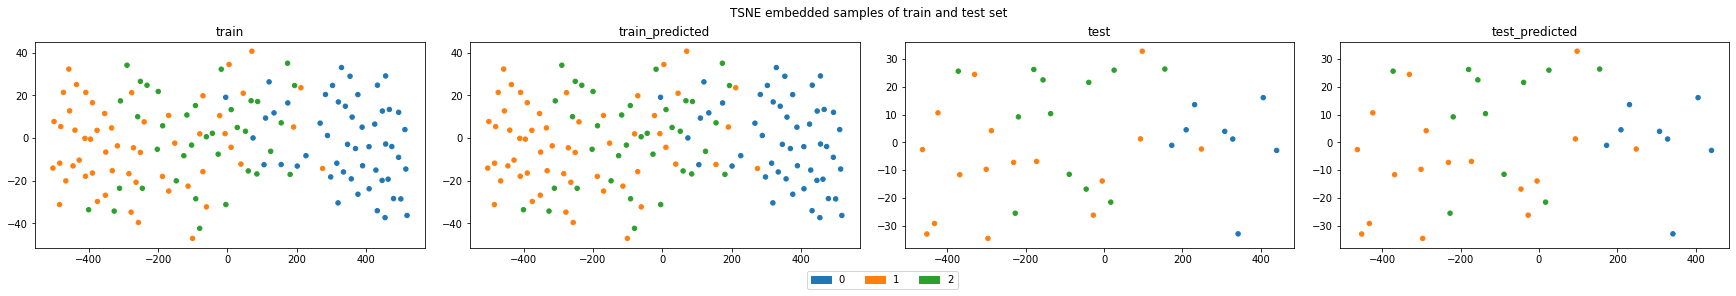

In [4]:
import numpy as np
pred_y_train = np.argmax(model.predict(transformed_dataset.x_train), axis=1)
pred_y_test = np.argmax(model.predict(transformed_dataset.x_test), axis=1)

datasets = {
    'train': (tsne_dataset.x_train, dataset.y_train),
    'train_predicted': (tsne_dataset.x_train, pred_y_train),
    'test': (tsne_dataset.x_test, dataset.y_test),
    'test_predicted': (tsne_dataset.x_test, pred_y_test)
}
plot_datasets(datasets, s=20, suptitle="TSNE embedded samples of train and test set")

## Calculating influences for small neural networks

The following sectione elaborates the calculation of influences through a neural network. It is noteworthy that the full Hessian matrix is constructed and used for inverting the gradients.

In [ ]:
from valuation.influence.general import influences

test_influences = influences(model, transformed_dataset.x_test, transformed_dataset.y_test)
train_influences = influences(model, transformed_dataset.x_train, transformed_dataset.y_train, transformed_dataset.x_test, transformed_dataset.y_test)

In [6]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)

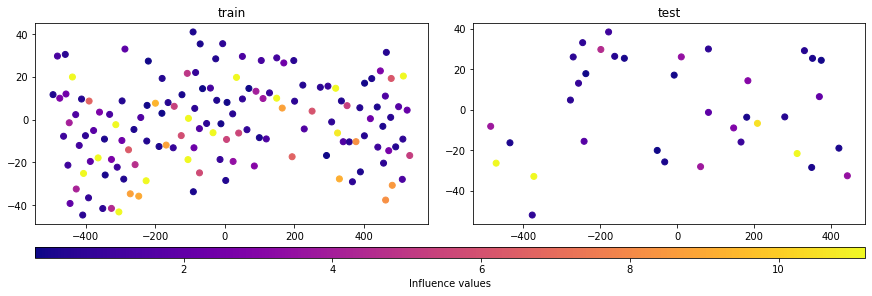

In [10]:
influence_datasets = {
    'train': (tsne_dataset.x_train, mean_train_influences),
    'test': (tsne_dataset.x_test, mean_test_influences),
}
plot_datasets(influence_datasets)